In [1]:
from pathlib import Path
import json, random, os
import numpy as np
import torch
import random

In [2]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_seed(42)

In [4]:
REPO_ROOT = (Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks") 
             else Path.cwd())
CKPT_DIR = REPO_ROOT / "checkpoints" / "classification"
RES_DIR  = REPO_ROOT / "results"
MET_DIR  = RES_DIR / "metrics"
FIG_DIR  = RES_DIR / "figures"
for p in [CKPT_DIR, MET_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)
print("checkpoints →", CKPT_DIR)
print("metrics →", MET_DIR)
print("figures →", FIG_DIR)

checkpoints → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\classification
metrics → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\metrics
figures → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures


Build stratified splits (70/15/15) from foldered data

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import datasets as tvds

In [6]:
from pathlib import Path


DATA_ROOT = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\downloads\classification\blood_cell_images_for_cancer_detection")
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"

classes = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Found class folders:", classes)

Found class folders: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


In [7]:
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"

In [8]:
from torchvision import transforms

img_size = 224
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(img_size * 1.15)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [9]:
from torchvision import datasets as tvds
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

full_ds = tvds.ImageFolder(DATA_ROOT, transform=val_tfms)
class_names = full_ds.classes
y = [s[1] for s in full_ds.samples]
N = len(full_ds)
num_classes = len(class_names)
print(f"Found {N} images, {num_classes} classes:", class_names)



Found 5000 images, 5 classes: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


In [10]:
cnt = Counter(y)
for i, cls in enumerate(class_names):
    print(f"{cls}: {cnt[i]}")

basophil: 1000
erythroblast: 1000
monocyte: 1000
myeloblast: 1000
seg_neutrophil: 1000


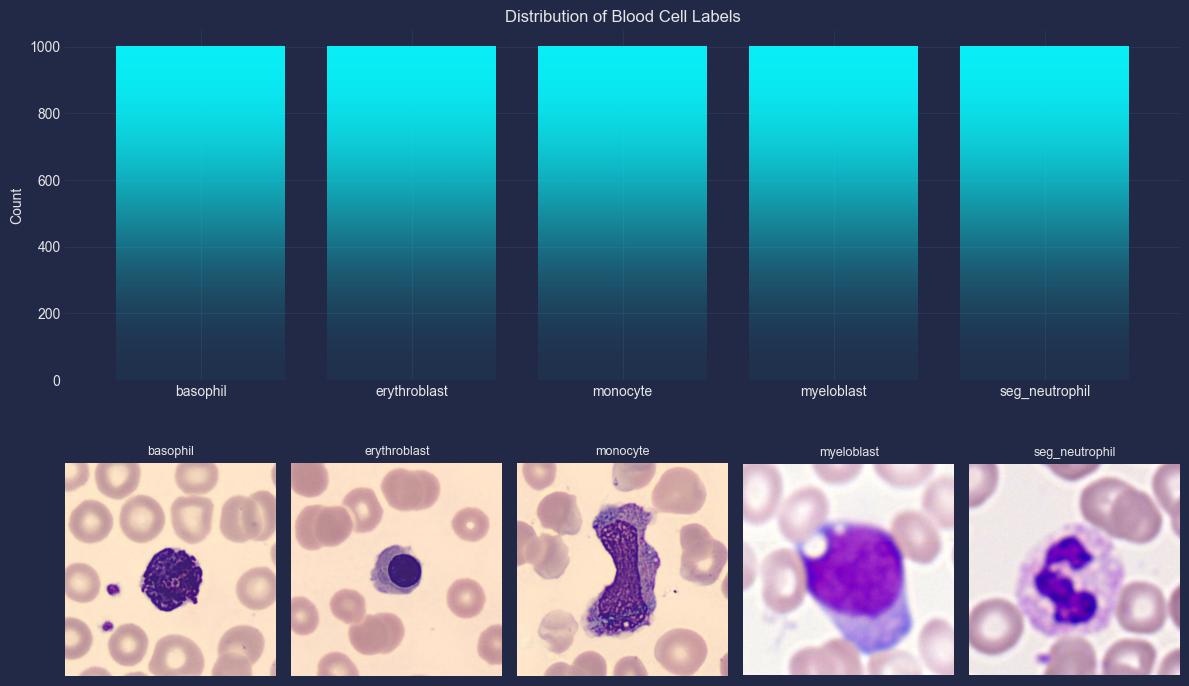

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


try:
    import mplcyberpunk
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mplcyberpunk"])
    import mplcyberpunk

labels = list(class_names)                  # e.g. ['basophil','erythroblast','monocyte','myeloblast','seg_neutrophil']
y_np = np.asarray(y, dtype=int)             

# counts per class 
counts = [int((y_np == i).sum()) for i in range(len(labels))]

first_sample = {}
for path, lab in full_ds.samples:
    if lab not in first_sample:
        first_sample[lab] = path
    if len(first_sample) == len(labels):
        break

# ---- plot ----
plt.style.use("cyberpunk")                  
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=len(labels), height_ratios=[1.0, 1.2])

# Bar chart (top row)
ax_bar = fig.add_subplot(gs[0, :])
xpos = np.arange(len(labels))
bars = ax_bar.bar(xpos, counts)
mplcyberpunk.add_bar_gradient(bars=bars)
mplcyberpunk.make_lines_glow(ax=ax_bar)

ax_bar.set_xticks(xpos, labels)            
ax_bar.set_ylabel("Count")
ax_bar.set_title("Distribution of Blood Cell Labels")


for i, lab_name in enumerate(labels):
    ax = fig.add_subplot(gs[1, i])
    img = Image.open(first_sample[i]).convert("RGB")
    ax.imshow(img)
    ax.set_title(lab_name, fontsize=9)
    ax.axis("off")

fig.tight_layout()
plt.show()

In [12]:
from pathlib import Path
import os, json
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

REPO_ROOT = (Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks")
             else Path.cwd())

PROCESSED_DIR = REPO_ROOT / "data" / "processed" / "classification" / "blood_cell_images_for_cancer_detection_processed"
SPLIT_DIR = PROCESSED_DIR / "splits" / "fold0"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", SPLIT_DIR)

Saving to: c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\classification\blood_cell_images_for_cancer_detection_processed\splits\fold0


In [13]:
def stratified_split_indices(y, test_size=0.15, val_size=0.15, seed=42):
    idx = np.arange(len(y))
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    trainval_idx, test_idx = next(sss1.split(idx, y))
    val_rel = val_size / (1.0 - test_size)
    y_trainval = np.array(y)[trainval_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_rel, random_state=seed)
    train_idx, val_idx = next(sss2.split(trainval_idx, y_trainval))
    return trainval_idx[train_idx].tolist(), trainval_idx[val_idx].tolist(), test_idx.tolist()

train_idx, val_idx, test_idx = stratified_split_indices(y, seed=42)

def save_split(indices, filename):
    rows = []
    for i in indices:
        path, label = full_ds.samples[i]
        rows.append({
            "path": os.path.relpath(path, REPO_ROOT),
            "label": int(label),
            "class_name": class_names[label],
        })
    df = pd.DataFrame(rows).sort_values("path")
    df.to_csv(SPLIT_DIR / filename, index=False)
    return df

df_train = save_split(train_idx, "train.csv")
df_val   = save_split(val_idx,   "val.csv")
df_test  = save_split(test_idx,  "test.csv")


label_map = {int(v): str(k) for k, v in full_ds.class_to_idx.items()}
with open(SPLIT_DIR / "label_map.json", "w") as f:
    json.dump(label_map, f, indent=2)

print("train/val/test sizes:", df_train.shape, df_val.shape, df_test.shape)
print("label_map:", label_map)

train/val/test sizes: (3500, 3) (750, 3) (750, 3)
label_map: {0: 'basophil', 1: 'erythroblast', 2: 'monocyte', 3: 'myeloblast', 4: 'seg_neutrophil'}


Load from those CSVs → build Datasets & DataLoaders

In [14]:
from PIL import Image
import torch, random
from torch.utils.data import Dataset, DataLoader

# transforms: train_tfms / val_tfms defined earlier
with open(SPLIT_DIR / "label_map.json") as f:
    label_map = {int(k): v for k, v in json.load(f).items()}
class_names = [label_map[i] for i in sorted(label_map)]
num_classes = len(class_names)
print("class_names:", class_names)

class CSVDataset(Dataset):
    def __init__(self, csv_path, transform=None, repo_root=REPO_ROOT):
        df = pd.read_csv(csv_path)
        self.paths = [repo_root / p for p in df["path"].tolist()]
        self.labels = df["label"].astype(int).tolist()
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

train_ds = CSVDataset(SPLIT_DIR / "train.csv", transform=train_tfms)
val_ds   = CSVDataset(SPLIT_DIR / "val.csv",   transform=val_tfms)
test_ds  = CSVDataset(SPLIT_DIR / "test.csv",  transform=val_tfms)

def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)

g = torch.Generator(); g.manual_seed(42)

batch_size, num_workers = 32, 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers,
                          pin_memory=True, worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers,
                          pin_memory=True, worker_init_fn=seed_worker, generator=g)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers,
                          pin_memory=True, worker_init_fn=seed_worker, generator=g)

len(train_ds), len(val_ds), len(test_ds), num_classes


class_names: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


(3500, 750, 750, 5)

Model (ResNet-18), weighted CE, optimizer, scheduler

In [15]:
import torch.nn as nn, torch.optim as optim
from torchvision import models as tvm
from torchvision.models import ResNet18_Weights
from collections import Counter

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [ ]:
cnt = Counter(pd.read_csv(SPLIT_DIR / "train.csv")["label"].tolist())
freqs = np.array([cnt.get(i, 0) for i in range(num_classes)], dtype=float)
weights = (1.0 / (freqs + 1e-9)); weights = weights / weights.sum() * num_classes
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
print("train class counts:", cnt)

model = tvm.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


train class counts: Counter({0: 700, 1: 700, 2: 700, 3: 700, 4: 700})


In [18]:
import torch

def feature_map_shapes(model, input_size=(1,3,224,224), device="cpu"):
    x = torch.randn(*input_size, device=device)
    wanted = ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]
    modules = dict(model.named_modules())
    shapes = {}

    handles = []
    for name in wanted:
        m = modules[name]
        def hook(n):
            def _h(_m, _in, out): shapes[n] = tuple(out.shape)
            return _h
        handles.append(m.register_forward_hook(hook(name)))

    with torch.no_grad():
        _ = model(x)

    for h in handles:
        h.remove()
    return shapes

print(feature_map_shapes(model, device=device))


{'conv1': (1, 64, 112, 112), 'layer1': (1, 64, 56, 56), 'layer2': (1, 128, 28, 28), 'layer3': (1, 256, 14, 14), 'layer4': (1, 512, 7, 7), 'avgpool': (1, 512, 1, 1)}


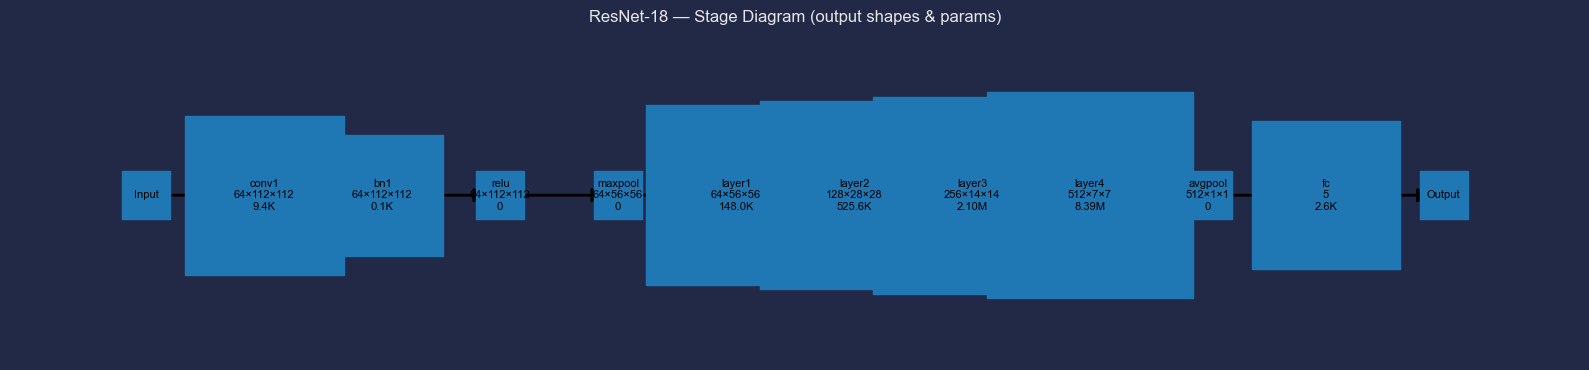

Saved: c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\resnet18_arch_cyberpunk.png


In [19]:
# Cyberpunk model diagram (ResNet-18)
import math, json
import numpy as np
import matplotlib.pyplot as plt

# install once if needed
try:
    import networkx as nx
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
    import networkx as nx

try:
    import mplcyberpunk
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mplcyberpunk"])
    import mplcyberpunk

import torch
from torch import nn

# --- collect feature-map shapes via forward hooks ---
def feature_map_shapes(model, input_size=(1,3,224,224), device="cpu"):
    wanted = ["conv1","bn1","relu","maxpool","layer1","layer2","layer3","layer4","avgpool","fc"]
    modules = dict(model.named_modules())
    shapes = {}

    handles = []
    for name in wanted:
        if name not in modules:  # defensive
            continue
        m = modules[name]
        def make_hook(n):
            def _hook(_m, _in, out):
                if isinstance(out, (tuple, list)):
                    out = out[0]
                try:
                    shapes[n] = tuple(out.shape)
                except Exception:
                    shapes[n] = None
            return _hook
        handles.append(m.register_forward_hook(make_hook(name)))

    x = torch.randn(*input_size, device=device)
    model.eval()
    with torch.no_grad():
        _ = model(x)

    for h in handles:
        h.remove()
    return shapes

shapes = feature_map_shapes(model, device=device)

# --- parameter counts per stage ---
def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

stage_modules = {
    "conv1": model.conv1,
    "bn1": model.bn1,
    "relu": model.relu,          # 0 params
    "maxpool": model.maxpool,    # 0 params
    "layer1": model.layer1,
    "layer2": model.layer2,
    "layer3": model.layer3,
    "layer4": model.layer4,
    "avgpool": model.avgpool,    # 0 params
    "fc": model.fc,
}

param_counts = {k: (count_params(v) if hasattr(v, "parameters") else 0) for k,v in stage_modules.items()}

# --- build a simple left-to-right graph ---
stages = ["Input","conv1","bn1","relu","maxpool","layer1","layer2","layer3","layer4","avgpool","fc","Output"]
G = nx.DiGraph()
for s in stages:
    G.add_node(s)

for a,b in zip(stages[:-1], stages[1:]):
    G.add_edge(a,b)

# node labels with shapes/params
def shape_str(name):
    shp = shapes.get(name)
    if shp is None: return ""
    # show channel x H x W (or features)
    if len(shp) == 4:
        _, C, H, W = shp
        return f"{C}×{H}×{W}"
    elif len(shp) == 2:
        _, F = shp
        return f"{F}"
    return "?"

labels = {}
for s in stages:
    if s in ("Input","Output"):
        labels[s] = s
        continue
    params = param_counts.get(s, 0)
    ptxt = f"{params/1e6:.2f}M" if params>=1e6 else (f"{params/1e3:.1f}K" if params>0 else "0")
    shp = shape_str(s)
    labels[s] = f"{s}\n{shp}\n{ptxt}"

# positions: nice horizontal line
pos = {s: (i, 0) for i, s in enumerate(stages)}

# node sizes scaled by params (with a floor so 0-param ops still visible)
sizes = []
for s in stages:
    p = param_counts.get(s, 0)
    size = 1200 + 0 if p==0 else 1200 + int(3000 * math.log10(p+10))  # crude scaling
    sizes.append(size)

# --- plot in cyberpunk style ---
plt.style.use("cyberpunk")
fig, ax = plt.subplots(figsize=(16, 3.8))
nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowstyle='-|>', arrowsize=20, width=2)
nx.draw_networkx_nodes(G, pos, ax=ax, node_shape='s', node_size=sizes)
nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=8)

ax.set_title("ResNet-18 — Stage Diagram (output shapes & params)")
ax.axis("off")
mplcyberpunk.make_lines_glow(ax=ax)

# save figure
FIG_DIR = (Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks")
           else Path.cwd()) / "results" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "resnet18_arch_cyberpunk.png"
plt.tight_layout()
plt.savefig(out_path, dpi=160)
plt.show()
print("Saved:", out_path)


In [20]:
from torch.cuda.amp import autocast, GradScaler
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from tqdm.auto import tqdm
import math, json

c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
CKPT_DIR = REPO_ROOT / "checkpoints" / "classification"
MET_DIR  = REPO_ROOT / "results" / "metrics"
CKPT_DIR.mkdir(parents=True, exist_ok=True)
MET_DIR.mkdir(parents=True, exist_ok=True)

In [22]:

scaler = GradScaler(enabled=torch.cuda.is_available())

def run_epoch(loader, train=True):
    model.train(train)
    loss_sum = 0.0
    logits_all, targets_all = [], []
    for x, yb in tqdm(loader, leave=False):
        x, yb = x.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(x); loss = criterion(logits, yb)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(x); loss = criterion(logits, yb)
        loss_sum += loss.item() * x.size(0)
        logits_all.append(logits.detach().float().cpu())
        targets_all.append(yb.detach().long().cpu())

    loss_epoch = loss_sum / len(loader.dataset)
    logits_all = torch.cat(logits_all); targets_all = torch.cat(targets_all)
    auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(logits_all.softmax(1), targets_all).item()
    acc   = MulticlassAccuracy(num_classes=num_classes, average="macro")(logits_all.argmax(1), targets_all).item()
    return loss_epoch, acc, auroc

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7136\3101211728.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [24]:
from pathlib import Path
import time, random
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # avoid hangs on bad files

REPO_ROOT = (Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks")
             else Path.cwd())
SPLIT_DIR = REPO_ROOT / "data" / "processed" / "classification" / "blood_cell_images_for_cancer_detection_processed" / "splits" / "fold0"

df = pd.read_csv(SPLIT_DIR / "train.csv")
paths = [REPO_ROOT / p for p in df["path"].sample(5, random_state=0)]
for p in paths:
    t0 = time.time()
    img = Image.open(p).convert("RGB")
    _ = img.size
    print(p.name, f"{(time.time()-t0):.3f}s")

ERB_587815.jpg 0.011s
BA_275300.jpg 0.009s
NGS_0083.jpg 0.008s
MYO_1644.jpg 0.009s
MO_262081.jpg 0.010s


In [25]:
# Rebuild ultra-stable loaders (Windows-safe)
from torch.utils.data import DataLoader
import torch

pin = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                          num_workers=0, pin_memory=pin)   # 👈 workers=0
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                          num_workers=0, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                          num_workers=0, pin_memory=pin)

print("steps/epoch:", len(train_loader), len(val_loader), len(test_loader))

# Smoke test: does a batch come through?
xb, yb = next(iter(train_loader))
print("first batch:", xb.shape, yb.shape)


steps/epoch: 110 24 24
first batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [26]:
# (Optional) a little more speed, not strictly deterministic:
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

def fit_simple(epochs=1):
    model.train()
    for ep in range(1, epochs+1):
        tot, n = 0.0, 0
        for i,(x,y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(x)
            loss = criterion(out, y)
            loss.backward(); optimizer.step()
            tot += loss.item() * x.size(0); n += x.size(0)
            if (i+1) % 20 == 0:
                print(f"[ep {ep}] step {i+1}/{len(train_loader)}  loss {tot/n:.4f}", end="\r")
        print(f"\n[ep {ep}] train loss {tot/n:.4f}")
        scheduler.step()

fit_simple(epochs=1)

[ep 1] step 100/110  loss 0.2049
[ep 1] train loss 0.1969


In [29]:
def fit(epochs=20, ckpt_name="cls_bloodcells_resnet18.pt"):
    best = -math.inf; hist = []
    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_auc = run_epoch(train_loader, True)
        va_loss, va_acc, va_auc = run_epoch(val_loader,   False)
        scheduler.step()
        hist.append({"epoch":ep,"train_loss":tr_loss,"train_acc":tr_acc,"train_auroc":tr_auc,
                     "val_loss":va_loss,"val_acc":va_acc,"val_auroc":va_auc,"lr":scheduler.get_last_lr()[0]})
        print(f"[{ep:03d}] train: loss {tr_loss:.4f} acc {tr_acc:.3f} auroc {tr_auc:.3f} | "
              f"val: loss {va_loss:.4f} acc {va_acc:.3f} auroc {va_auc:.3f}")
        if va_auc > best:
            best = va_auc
            torch.save({"state_dict": model.state_dict(),
                        "class_names": class_names,
                        "num_classes": num_classes},
                       CKPT_DIR / ckpt_name)
    with open(MET_DIR / "bloodcells_resnet18_history.json", "w") as f:
        json.dump(hist, f, indent=2)
    print("Best val AUROC:", best)

fit(epochs=epochs)

  0%|          | 0/110 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7136\3101211728.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
  0%|          | 0/24 [00:00<?, ?it/s]           C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7136\3101211728.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


[001] train: loss 0.1412 acc 0.951 auroc 0.997 | val: loss 0.0834 acc 0.972 auroc 1.000


[002] train: loss 0.0761 acc 0.974 auroc 0.999 | val: loss 0.0262 acc 0.992 auroc 1.000


[003] train: loss 0.0647 acc 0.975 auroc 0.999 | val: loss 0.0134 acc 0.996 auroc 1.000


[004] train: loss 0.0735 acc 0.980 auroc 0.999 | val: loss 0.0076 acc 0.999 auroc 1.000


[005] train: loss 0.0638 acc 0.977 auroc 0.999 | val: loss 0.0204 acc 0.992 auroc 1.000


[006] train: loss 0.0801 acc 0.973 auroc 0.999 | val: loss 0.0249 acc 0.992 auroc 1.000


[007] train: loss 0.0589 acc 0.978 auroc 0.999 | val: loss 0.0142 acc 0.996 auroc 1.000


[008] train: loss 0.0444 acc 0.986 auroc 1.000 | val: loss 0.0045 acc 1.000 auroc 1.000


[009] train: loss 0.0433 acc 0.983 auroc 1.000 | val: loss 0.0067 acc 0.999 auroc 1.000


[010] train: loss 0.0372 acc 0.989 auroc 1.000 | val: loss 0.0030 acc 0.999 auroc 1.000


[011] train: loss 0.0287 acc 0.988 auroc 1.000 | val: loss 0.0035 acc 0.997 auroc 1.000


[012] train: loss 0.0245 acc 0.992 auroc 1.000 | val: loss 0.0018 acc 1.000 auroc 1.000


[013] train: loss 0.0260 acc 0.990 auroc 1.000 | val: loss 0.0043 acc 0.997 auroc 1.000


[014] train: loss 0.0306 acc 0.986 auroc 1.000 | val: loss 0.0027 acc 0.999 auroc 1.000


[015] train: loss 0.0204 acc 0.992 auroc 1.000 | val: loss 0.0009 acc 1.000 auroc 1.000


[016] train: loss 0.0205 acc 0.993 auroc 1.000 | val: loss 0.0007 acc 1.000 auroc 1.000


[017] train: loss 0.0187 acc 0.993 auroc 1.000 | val: loss 0.0008 acc 1.000 auroc 1.000


[018] train: loss 0.0201 acc 0.991 auroc 1.000 | val: loss 0.0008 acc 1.000 auroc 1.000


[019] train: loss 0.0277 acc 0.991 auroc 1.000 | val: loss 0.0008 acc 1.000 auroc 1.000


[020] train: loss 0.0264 acc 0.990 auroc 1.000 | val: loss 0.0006 acc 1.000 auroc 1.000
Best val AUROC: 1.0


In [27]:
# --- NOTE: DataLoader change for Windows reliability -----------------------------------------
# Problem: Training appeared "stuck at 0%" on the first epoch. On Windows, DataLoader uses
# process "spawn" and sometimes hangs/starts very slowly when num_workers > 0 in notebooks.
#
# What we changed:
#   • Set num_workers = 0  → single-process data loading (most reliable on Windows).
#   • Kept pin_memory = True when CUDA is available (faster host→GPU copies).
#   • (Optional) Enabled cudnn.benchmark for speed; this does NOT change the model, only runtime.
#
# What did NOT change:
#   • The MODEL (ResNet-18 CNN), LOSS, OPTIMIZER, and METRICS are exactly the same.
#   • Training results/accuracy are unaffected—only wall-clock speed may be slower.
#
# Trade-off:
#   • num_workers=0 is slower than parallel loading, but avoids Windows worker hangs.
#
# When to revisit:
#   • After it runs stably, try num_workers=2 with persistent_workers=True.
#     If it stalls again, revert to 0.
# ----------------------------------------------------------------------------------------------


In [32]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [33]:
import json, torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAUROC
from tqdm.auto import tqdm

In [34]:
CKPT = REPO_ROOT / "checkpoints" / "classification" / "cls_bloodcells_resnet18.pt"
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state["state_dict"]); model.eval()

# collect
logits_list, targets_list = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, leave=False):
        logits_list.append(model(x.to(device)).cpu())
        targets_list.append(y.cpu())

logits = torch.cat(logits_list); targets = torch.cat(targets_list)
probs = logits.softmax(1).numpy()
preds = probs.argmax(1); targets_np = targets.numpy()

test_auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(torch.tensor(probs), torch.tensor(targets_np)).item()
test_acc = float((preds == targets_np).mean())
report = classification_report(targets_np, preds, target_names=class_names, output_dict=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7136\1514533282.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(CKPT, map_location=device)


Saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\metrics\cls_bloodcells_resnet18_test.json


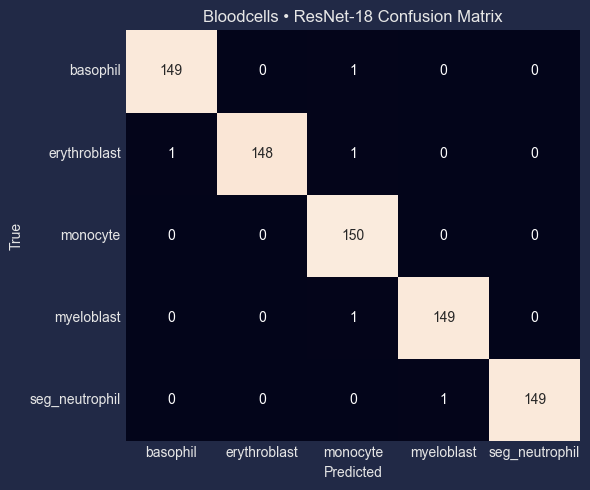

Saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\cls_bloodcells_resnet18_confusion_matrix.png


In [35]:
MET_DIR = REPO_ROOT / "results" / "metrics"; MET_DIR.mkdir(parents=True, exist_ok=True)
with open(MET_DIR / "cls_bloodcells_resnet18_test.json", "w") as f:
    json.dump({"dataset":"bloodcells","model":"resnet18","num_classes":num_classes,
               "test_macro_auroc": test_auroc, "test_accuracy": test_acc,
               "classification_report": report}, f, indent=2)
print("Saved →", MET_DIR / "cls_bloodcells_resnet18_test.json")

# confusion matrix figure
cm = confusion_matrix(targets_np, preds)
FIG_DIR = REPO_ROOT / "results" / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Bloodcells • ResNet-18 Confusion Matrix")
plt.tight_layout()
fig_path = FIG_DIR / "cls_bloodcells_resnet18_confusion_matrix.png"
plt.savefig(fig_path, dpi=150); plt.show()
print("Saved →", fig_path)

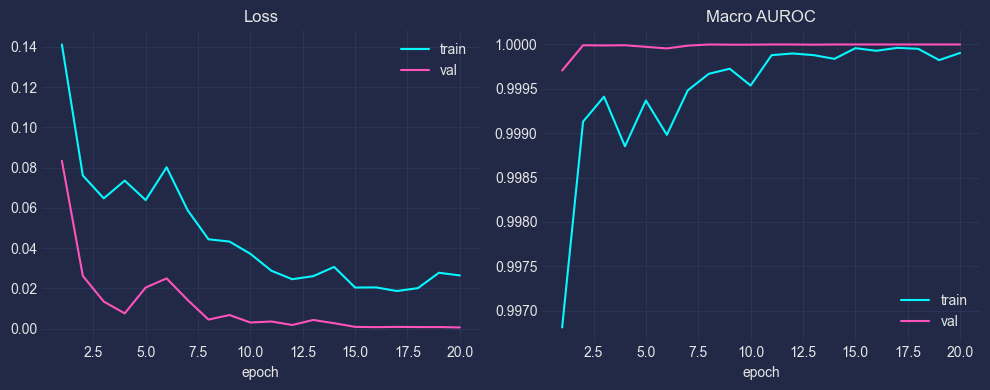

In [36]:
import json, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

hist_path = REPO_ROOT / "results" / "metrics" / "bloodcells_resnet18_history.json"
hist = json.loads(Path(hist_path).read_text())
epochs = [h["epoch"] for h in hist]
tr_loss = [h["train_loss"] for h in hist]; va_loss = [h["val_loss"] for h in hist]
tr_auc  = [h["train_auroc"] for h in hist]; va_auc  = [h["val_auroc"] for h in hist]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(epochs, tr_loss, label="train"); plt.plot(epochs, va_loss, label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.legend()
plt.subplot(1,2,2); plt.plot(epochs, tr_auc, label="train"); plt.plot(epochs, va_auc, label="val")
plt.title("Macro AUROC"); plt.xlabel("epoch"); plt.legend()
plt.tight_layout(); plt.show()


In [38]:
%pip install onnx onnxruntime

   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
    --------------------------------------- 0.3/16.5 MB ? eta -:--:--
   ---- ----------------------------------- 1.8/16.5 MB 7.2 MB/s eta 0:00:03
   -------- ------------------------------- 3.4/16.5 MB 9.1 MB/s eta 0:00:02
   ------------ --------------------------- 5.0/16.5 MB 7.7 MB/s eta 0:00:02
   ----------------- ---------------------- 7.3/16.5 MB 8.7 MB/s eta 0:00:02
   ----------------------- ---------------- 9.7/16.5 MB 9.2 MB/s eta 0:00:01
   ----------------------------- ---------- 12.1/16.5 MB 9.7 MB/s eta 0:00:01
   ---------------------------------- ----- 14.2/16.5 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------  16.3/16.5 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 16.5/16.5 MB 9.3 MB/s  0:00:01
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.7 MB 10.7 MB/s eta 0:00:01
   -------------- 

In [39]:
# ONNX
onnx_out = REPO_ROOT / "exports" / "onnx" / "cls_bloodcells_resnet18.onnx"
dummy = torch.randn(1, 3, 224, 224, device=device)
model.eval()
torch.onnx.export(model, dummy, onnx_out.as_posix(),
                  input_names=["input"], output_names=["logits"],
                  opset_version=17, dynamic_axes={"input": {0:"batch"}, "logits": {0:"batch"}})
print("ONNX saved →", onnx_out)

ONNX saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\onnx\cls_bloodcells_resnet18.onnx


In [40]:
# TorchScript (trace)
ts_out = REPO_ROOT / "exports" / "torchscript" / "cls_bloodcells_resnet18.pt"
traced = torch.jit.trace(model, dummy)
traced.save(ts_out.as_posix())
print("TorchScript saved →", ts_out)

TorchScript saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\torchscript\cls_bloodcells_resnet18.pt
